<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 3

### Analyze AG_NEWS_SUBSET Data <br>

AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity.<br> 

For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html<br> 


The AG's news topic classification dataset is constructed by choosing 4 largest classes (**World**, **Sports**, **Business**, and **Sci/Tech**) from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.<br>

Homepage: https://arxiv.org/abs/1509.01626<br>

Source code: tfds.text.AGNewsSubset

Versions:

1.0.0 (default): No release notes.
Download size: 11.24 MiB

Dataset size: 35.79 MiB

<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div>

## Import packages 

In [67]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

from timeit import default_timer as timer #import a timer
from datetime import datetime

In [68]:
#tf.get_logger().setLevel('INFO')

In [69]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Verify TensorFlow Version and Keras Version

In [70]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.6.0


In [71]:
print("Keras version: ", keras.__version__)

Keras version:  2.6.0


### Functions For Research Assignment 

In [72]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions)))) 

In [73]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [74]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

### Mount Google Drive to Colab Environment

In [75]:
#from google.colab import drive
#drive.mount('/content/gdrive')

###  TensorFlow Datasets Information<br>
<div class="alert alert-block alert-info">
    <b> ag_news_subset</b><br>
    See https://www.tensorflow.org/datasets/catalog/ag_news_subset
    </div>

Get all the words in the documents (as well as the number of words in each document) by using the encoder to get the indices associated with each token and then translating the indices to tokens. But first we need to get the "unpadded" new articles so that we can get their length.

In [76]:
#register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# https://www.tensorflow.org/datasets/splits
# The full `train` and `test` splits, interleaved together.
ri = tfds.core.ReadInstruction('train') + tfds.core.ReadInstruction('test')
dataset_all, info = tfds.load('ag_news_subset', with_info=True,  split=ri, as_supervised=True)

2021-11-05 14:20:24.157391: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 14:20:24.165652: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 14:20:24.166257: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
I1105 14:20:24.166911 140488906356608 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I1105 14:20:24.167621 140488906356608 dataset_info.py:361] Load dataset info from /root/tensorflow_datasets/ag_news_subset/1.0.0
I1105 14:20:24.168826 140488906356608 download_and_prepare.py:138] download_and_prep

###  Exploratory Analysis AG News Subset

**Get information about the ag_news_subset dataset. We combined the training and test data for a total of 127,600 news articles.**

In [77]:
print(info)

tfds.core.DatasetInfo(
    name='ag_news_subset',
    version=1.0.0,
    description='AG is a collection of more than 1 million news articles.
News articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.
ComeToMyHead is an academic news search engine which has been running since July, 2004.
The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc),
information retrieval (ranking, search, etc), xml, data compression, data streaming,
and any other non-commercial activity.
For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html .

The AG's news topic classification dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the dataset above.
It is used as a text classification benchmark in the following paper:
Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advanc

In [78]:
tfds.as_dataframe(dataset_all.take(10),info)

,description,label
0,"AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.",3 (Sci/Tech)
1,Reuters - Major League Baseball\Monday announced a decision on the appeal filed by Chicago Cubs\pitcher Kerry Wood regarding a suspension stemming from an\incident earlier this season.,1 (Sports)
2,"President Bush #39;s quot;revenue-neutral quot; tax reform needs losers to balance its winners, and people claiming the federal deduction for state and local taxes may be in administration planners #39; sights, news reports say.",2 (Business)
3,"Britain will run out of leading scientists unless science education is improved, says Professor Colin Pillinger.",3 (Sci/Tech)
4,"London, England (Sports Network) - England midfielder Steven Gerrard injured his groin late in Thursday #39;s training session, but is hopeful he will be ready for Saturday #39;s World Cup qualifier against Austria.",1 (Sports)
5,TOKYO - Sony Corp. is banking on the \$3 billion deal to acquire Hollywood studio Metro-Goldwyn-Mayer Inc...,0 (World)
6,"Giant pandas may well prefer bamboo to laptops, but wireless technology is helping researchers in China in their efforts to protect the engandered animals living in the remote Wolong Nature Reserve.",3 (Sci/Tech)
7,"VILNIUS, Lithuania - Lithuania #39;s main parties formed an alliance to try to keep a Russian-born tycoon and his populist promises out of the government in Sunday #39;s second round of parliamentary elections in this Baltic country.",0 (World)
8,Witnesses in the trial of a US soldier charged with abusing prisoners at Abu Ghraib have told the court that the CIA sometimes directed abuse and orders were received from military command to toughen interrogations.,0 (World)
9,"Dan Olsen of Ponte Vedra Beach, Fla., shot a 7-under 65 Thursday to take a one-shot lead after two rounds of the PGA Tour qualifying tournament.",1 (Sports)


### Review Labels (Categories) 

In [79]:
print(f'There are {info.features["label"].num_classes} classes in the dataset.')
print(f'The class names are {info.features["label"].names}')

There are 4 classes in the dataset.
The class names are ['World', 'Sports', 'Business', 'Sci/Tech']


In [80]:
# classes dictionary
categories =dict(enumerate(info.features["label"].names))
categories

{0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}

The 127,600 news articles are evenly distributed among the 4 categories

In [81]:
train_categories = [categories[label] for label in dataset_all.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Sci/Tech', 31900), ('Sports', 31900), ('Business', 31900), ('World', 31900)]

### Preprocessing Data Create Input Pipeline

In [82]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# Example Approaches to Split Data Set
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:]','test[:1000]', 'test[1000:]'],
dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test[:]'],
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:114000]','train[114000:]', 'test[:]'],
                          as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset
# train_dataset, test_dataset = dataset['train'],dataset['test']

2021-11-05 14:20:43.210626: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 14:20:43.218456: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 14:20:43.219090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
I1105 14:20:43.219810 140012651964288 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I1105 14:20:43.220597 140012651964288 dataset_info.py:361] Load dataset info from /root/tensorflow_datasets/ag_news_subset/1.0.0
I1105 14:20:43.221756 140012651964288 download_and_prepare.py:138] download_and_prep

In [83]:
####  Dataset Splits (Training, Test, Validation)
#### .8934 Training, .0470 Test, .0596 Validation

In [84]:
len(train_dataset),len(validation_dataset),len(test_dataset) 
# len(train_dataset),len(test_dataset) 

(114000, 6000, 7600)

### Review Distribution of Categorical Labels for the 114000 training data (news articles)

In [85]:
from collections import Counter
train_categories = [categories[label] for label in train_dataset.map(lambda text, label: label).as_numpy_iterator()]
Counter(train_categories).most_common()

[('Business', 28531), ('Sports', 28495), ('World', 28491), ('Sci/Tech', 28483)]

Review Example with Interger Label(text, label pairs):

Review Example with Interger Label Encoded Classification(text, label pairs):

In [86]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('class: ', categories[label.numpy()])

text:  b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
class:  Sci/Tech


#### Preprocessing Shuffle Data for Training and Create Batches of `(text, label)` pairs:

In [87]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [88]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [89]:
for example, label in train_dataset.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"AP - Assets of the nation's retail money market mutual funds fell by  #36;1.17 billion in the latest week to  #36;849.98 trillion, the Investment Company Institute said Thursday."
 b"&lt;p&gt;\\&lt;/p&gt;&lt;p&gt;   LONDON (Reuters) - Oil scaled a new high above \\$55 a barrel\\Monday as a threat by Norwegian ship owners to halt production\\from the world's third biggest exporter stoked fears of a\\winter supply crunch.&lt;/p&gt;"
 b'The foreign ministers of Britain and Germany issued a joint warning to Iran on Tuesday to address international worries about its nuclear program, serving notice that Tehran must take action immediately.']

labels:  [2 2 0]
texts:  [b'KNOXVILLE, Tenn. -- Jason Campbell threw for 252 yards and two touchdowns, and No. 8 Auburn proved itself as a national title contender by overwhelming No.'
 b' SINGAPORE (Reuters) - Oil prices stayed close to \\$49 a  barrel on Thursday, supported by a forecast for an early cold  snap in the United States that cou

In [90]:
for example, label in train_dataset.take(2):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', [categories[n] for n in label.numpy()[:3]])
  print()

texts:  [b"KANSAS CITY, Mo. - Interstate Bakeries Corp., the nation's largest wholesaler baker whose products include Twinkies and Wonder Bread, filed for Chapter 11 bankruptcy protection early Wednesday..."
 b"AFP - Britain's Prince William went fox hunting, six weeks before the controversial centuries-old bloodsport is to be banned forever, a spokeswoman said."
 b" NEW YORK (Reuters) - World number one Roger Federer faces a  stern test in the first round of the U.S. Open after being  pitted against Spaniard Albert Costa in Wednesday's draw."]

labels:  ['World', 'World', 'Sports']

texts:  [b"AP - During the dot-com boom, people who didn't want to miss out on the Web and e-mail craze but didn't want to buy a real computer could get WebTV, which delivered the Internet through the warm, friendly glow of their TV sets."
 b'Brazilian tennis player Ricardo Mello has upset top seed Vince Spadea to win the hard court event in Delray Beach, Florida. Mello made his first appearance in an ATP 

## Create the Text Encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `experimental.preprocessing.TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:
The processing of each sample contains the following steps:

    standardize each sample (usually lowercasing + punctuation stripping)
    split each sample into substrings (usually words)
    recombine substrings into tokens (usually ngrams)
    index tokens (associate a unique int value with each token)
    transform each sample using this index, either into a vector of ints or a dense float vector.


The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [91]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [92]:
vocab = np.array(encoder.get_vocabulary())
len(vocab)

1000

In [93]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'a', 'to', 'of', 'in', 'and', 'on', 'for',
       'that', '39s', 'with', 'its', 'as', 'at', 'is', 'said', 'by', 'it'],
      dtype='<U14')

Here are the 20 least frequent words.

In [94]:
vocab[-20:]

array(['black', 'turn', 'build', 'countrys', 'advanced', 'whose',
       'crisis', 'create', '23', 'sources', 'body', 'militant', 'hope',
       'event', 'started', 'ready', 'jones', 'lawsuit', 'focus',
       'singapore'], dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):<br>
Default Batch Size = 32

In [95]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 35, 162,   2,   1,   1,  80,  59,   1, 934,   4,   1,  65,   8,
          2, 233,   7, 555,   1,  37,   1, 934,   4, 349,   3, 638, 145,
         82, 249,   1,  75,   1,   2, 104, 209,   2,   1,   1,   1,   5,
         32, 870,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,   1, 386,   1,   1,  20,   1, 132,   1,   1,   1,   4, 125,
          2, 941, 171, 993,   6,   1,   1, 470,   1, 158,  24,  39,   1,
          6,  22,   1, 204,   3,   1,  50,   1,   2, 151,   1,   1,   1,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [535,   1, 253,  30, 343,   4, 352,  29,   1, 385, 113, 389, 331,
          1,   7,   3, 113,   1,  71, 968, 257,  43,   5,   1,   4,   1,
        209,   3,   1, 180,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [96]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"AP - During the dot-com boom, people who didn't want to miss out on the Web and e-mail craze but didn't want to buy a real computer could get WebTV, which delivered the Internet through the warm, friendly glow of their TV sets."
Round-trip:  ap during the [UNK] [UNK] people who [UNK] want to [UNK] out on the web and email [UNK] but [UNK] want to buy a real computer could get [UNK] which [UNK] the internet through the [UNK] [UNK] [UNK] of their tv [UNK]                   

Original:  b'Brazilian tennis player Ricardo Mello has upset top seed Vince Spadea to win the hard court event in Delray Beach, Florida. Mello made his first appearance in an ATP final a memorable one, defeating the American 7-6 (7/2), 6-3.'
Round-trip:  [UNK] [UNK] player [UNK] [UNK] has [UNK] top [UNK] [UNK] [UNK] to win the hard court event in [UNK] [UNK] florida [UNK] made his first [UNK] in an [UNK] final a [UNK] one [UNK] the american [UNK] [UNK] [UNK]                      

Original:  b'HOUSTON - J

## Create the model: Single Layer Unidirectional RNN (Experiment B1)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

1. The first layer is the `encoder`, which converts the text to a sequence of token indices.

2. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

3. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage to a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

1. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/BidirectionalRNN.png?raw=1">

In [97]:
from keras import backend as K
K.clear_session()

num_classes = 4
model = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.SimpleRNN(64)
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)                              
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

<div class="alert alert-block alert-success"> 
Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. </div>

<div class="alert alert-block alert-info"> 
<b>tf.keras.Model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/Model
</div>  

## Compile Model: Single Layer Unidirectional RNN (Experiment B1)

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [98]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [99]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True, True]


## Train the model: Single Layer Unidirectional RNN (Experiment B1)

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [100]:
start=datetime.now()

history = model.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

end=datetime.now()
print("Experiment B1 time:", end-start) 

Epoch 1/200
1782/1782 [==============================] - 146s 82ms/step - loss: 0.8344 - accuracy: 0.6594 - val_loss: 0.5103 - val_accuracy: 0.8235
Epoch 2/200
1782/1782 [==============================] - 144s 81ms/step - loss: 0.5204 - accuracy: 0.8202 - val_loss: 0.4655 - val_accuracy: 0.8383
Epoch 3/200
1782/1782 [==============================] - 145s 81ms/step - loss: 0.4920 - accuracy: 0.8303 - val_loss: 0.4606 - val_accuracy: 0.8380
Epoch 4/200
1782/1782 [==============================] - 143s 80ms/step - loss: 0.4803 - accuracy: 0.8342 - val_loss: 0.4565 - val_accuracy: 0.8422
Epoch 5/200
1782/1782 [==============================] - 143s 80ms/step - loss: 0.4752 - accuracy: 0.8362 - val_loss: 0.4524 - val_accuracy: 0.8423
Epoch 6/200
1782/1782 [==============================] - 144s 81ms/step - loss: 0.4680 - accuracy: 0.8386 - val_loss: 0.4639 - val_accuracy: 0.8392
Epoch 7/200
1782/1782 [==============================] - 144s 81ms/step - loss: 0.4626 - accuracy: 0.8401 - val_

In [101]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 1s 10ms/step - loss: 0.4630 - accuracy: 0.8371
Test Loss: 0.46298331022262573
Test Accuracy: 0.8371052742004395


## Plotting Performance Metrics: Single Layer Unidirectional RNN (Experiment B1)

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [102]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [103]:
history_df=pd.DataFrame(history_dict)
history_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.834,0.659,0.510,0.823
1,0.520,0.820,0.465,0.838
2,0.492,0.830,0.461,0.838
3,0.480,0.834,0.456,0.842
4,0.475,0.836,0.452,0.842
5,0.468,0.839,0.464,0.839
6,0.463,0.840,0.449,0.842


In [104]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

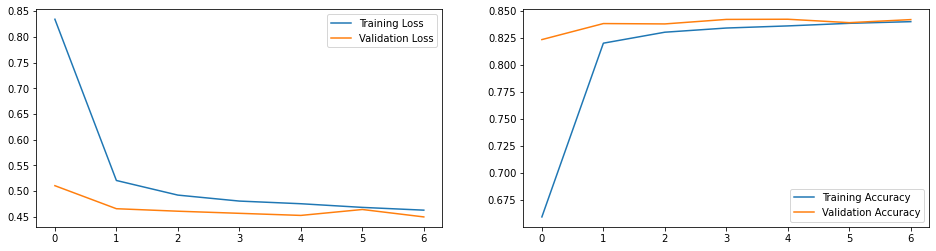

In [105]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Model Architecture Summary Single Layer Bidirectional RNN: Single Layer Unidirectional RNN (Experiment B1)

In [106]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                8256      
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 76,676
Trainable params: 76,676
Non-trainable params: 0
____________________________________________________

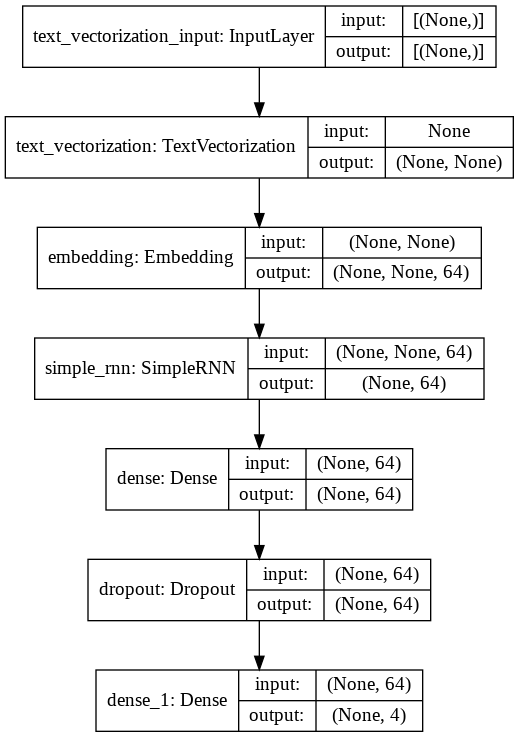

In [107]:
keras.utils.plot_model(model, "BiDirectionalLSTM.png", show_shapes=True)

##Create model by stacking two or more layers: Multi Layer Unidirectional Simple RNN (Experiment B2)



In [108]:
from keras import backend as K
K.clear_session()

num_classes = 4
model2 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.SimpleRNN(64, return_sequences=True)
                              ,tf.keras.layers.SimpleRNN(32)
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [109]:
model2.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [110]:
start=datetime.now()

history2 = model2.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

end=datetime.now()
print("Experiment B2 time:", end-start) 

Epoch 1/200
1782/1782 [==============================] - 286s 159ms/step - loss: 0.6518 - accuracy: 0.7504 - val_loss: 0.4833 - val_accuracy: 0.8396
Epoch 2/200
1782/1782 [==============================] - 280s 157ms/step - loss: 0.5093 - accuracy: 0.8257 - val_loss: 0.4807 - val_accuracy: 0.8323
Epoch 3/200
1782/1782 [==============================] - 282s 158ms/step - loss: 0.4775 - accuracy: 0.8374 - val_loss: 0.4403 - val_accuracy: 0.8531
Epoch 4/200
1782/1782 [==============================] - 282s 158ms/step - loss: 0.4619 - accuracy: 0.8416 - val_loss: 0.4284 - val_accuracy: 0.8542
Epoch 5/200
1782/1782 [==============================] - 283s 159ms/step - loss: 0.4497 - accuracy: 0.8457 - val_loss: 0.4388 - val_accuracy: 0.8552
Epoch 6/200
1782/1782 [==============================] - 279s 157ms/step - loss: 0.4322 - accuracy: 0.8515 - val_loss: 0.4490 - val_accuracy: 0.8516
Epoch 7/200
1782/1782 [==============================] - 279s 156ms/step - loss: 0.4188 - accuracy: 0.8551

In [111]:
test_loss, test_acc = model2.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 2s 17ms/step - loss: 0.4992 - accuracy: 0.8371
Test Loss: 0.49920281767845154
Test Accuracy: 0.8371052742004395


## Plotting Performance Metrics: Multi Layer Unidirectional Simple RNN (Experiment B2)

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [112]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [113]:
history2_df=pd.DataFrame(history_dict2)
history2_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
2,0.478,0.837,0.440,0.853
3,0.462,0.842,0.428,0.854
4,0.450,0.846,0.439,0.855
5,0.432,0.851,0.449,0.852
6,0.419,0.855,0.467,0.846


In [114]:
losses = history2.history['loss']
accs = history2.history['accuracy']
val_losses = history2.history['val_loss']
val_accs = history2.history['val_accuracy']
epochs = len(losses)

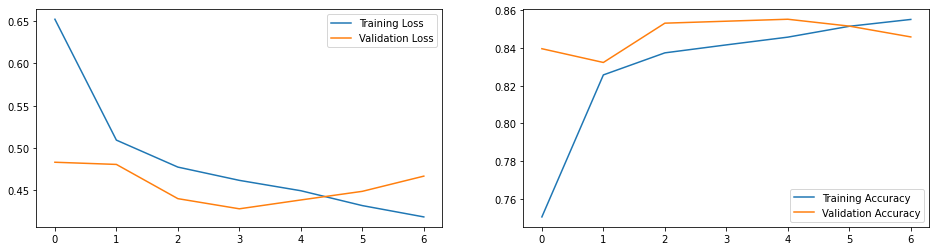

In [115]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [116]:
preds = model2.predict(test_dataset)

In [117]:
preds.shape

(7600, 4)

In [118]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [119]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.84%,99.56%,0.07%,1.79%,98.98%,0.23%,0.93%,9.40%,88.60%,1.59%,99.74%,0.54%,1.92%,93.59%,99.69%
Sports,99.11%,0.07%,0.01%,97.92%,0.20%,0.01%,98.98%,88.43%,0.15%,0.00%,0.04%,0.05%,0.00%,1.98%,0.02%
Business,0.01%,0.27%,3.43%,0.08%,0.48%,34.24%,0.01%,0.40%,5.08%,92.34%,0.14%,4.29%,97.90%,0.92%,0.24%
Sci/Tech,0.04%,0.10%,96.49%,0.21%,0.35%,65.52%,0.07%,1.77%,6.16%,6.07%,0.09%,95.12%,0.17%,3.51%,0.06%


#### Model Architecture Summary: Multi Layer Unidirectional Simple RNN (Experiment B2)

In [120]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 64)          8256      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                3104      
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2

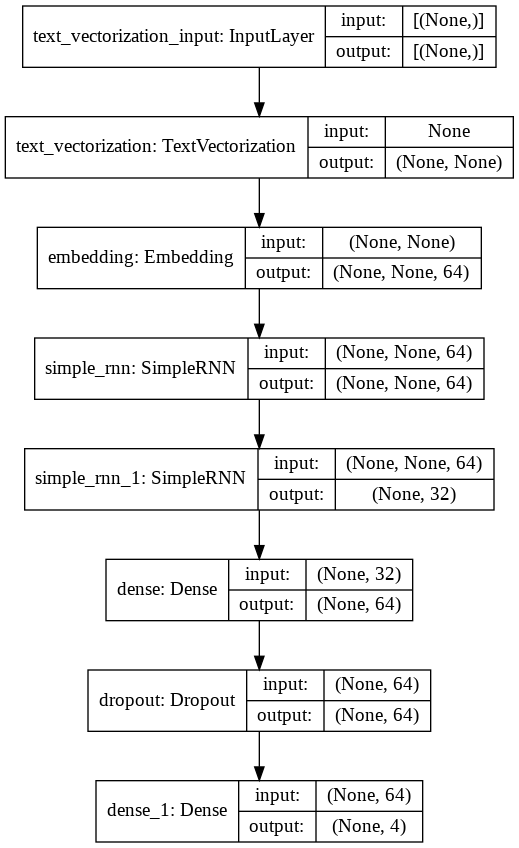

In [121]:
keras.utils.plot_model(model2, "2Layer_BiDirectionalLSTM.png", show_shapes=True)

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).


## Create the model : Single Layer Bidirectional Simple RNN (Experiment B3)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

1. The first layer is the `encoder`, which converts the text to a sequence of token indices.

2. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

3. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage to a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

1. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


<div class="alert alert-block alert-info">
    <b>tf.keras.layers.Bidirectional</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
    </div>

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/BidirectionalRNN.png?raw=1">

In [122]:
from keras import backend as K
K.clear_session()

num_classes = 4
model3 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary())
                              ,output_dim=64
                                # Use masking to handle the variable sequence lengths
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)                             
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # num_classes = 4
])

<div class="alert alert-block alert-success"> 
Please note that we choose to Keras sequential model here since all the layers in the model only have single input and produce single output. </div>

<div class="alert alert-block alert-info"> 
<b>tf.keras.Model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/Model
</div>  

## Compile Model: Single Layer Bidirectional Simple RNN (Experiment B3)

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [123]:
model3.compile(optimizer=tf.keras.optimizers.Adam(1e-4)
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](../../guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [124]:
print([layer.supports_masking for layer in model3.layers])

[False, True, True, True, True, True]


## Train the model: Single Layer Bidirectional Simple RNN (Experiment B3)

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [125]:
start=datetime.now()

history3 = model3.fit(train_dataset
                    ,epochs = 200
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

end=datetime.now()
print("Experiment B3 time:", end-start) 

Epoch 1/200
1782/1782 [==============================] - 277s 154ms/step - loss: 0.8232 - accuracy: 0.6580 - val_loss: 0.4974 - val_accuracy: 0.8278
Epoch 2/200
1782/1782 [==============================] - 273s 153ms/step - loss: 0.5036 - accuracy: 0.8285 - val_loss: 0.4396 - val_accuracy: 0.8463
Epoch 3/200
1782/1782 [==============================] - 272s 152ms/step - loss: 0.4627 - accuracy: 0.8425 - val_loss: 0.4223 - val_accuracy: 0.8525
Epoch 4/200
1782/1782 [==============================] - 271s 152ms/step - loss: 0.4389 - accuracy: 0.8494 - val_loss: 0.4195 - val_accuracy: 0.8522
Epoch 5/200
1782/1782 [==============================] - 273s 153ms/step - loss: 0.4257 - accuracy: 0.8538 - val_loss: 0.4066 - val_accuracy: 0.8562
Epoch 6/200
1782/1782 [==============================] - 274s 153ms/step - loss: 0.4153 - accuracy: 0.8566 - val_loss: 0.3971 - val_accuracy: 0.8565
Epoch 7/200
1782/1782 [==============================] - 272s 153ms/step - loss: 0.4055 - accuracy: 0.8584

In [126]:
test_loss, test_acc = model3.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 2s 16ms/step - loss: 0.3989 - accuracy: 0.8545
Test Loss: 0.39893579483032227
Test Accuracy: 0.8544737100601196


## Plotting Performance Metrics: Single Layer Simple RNN (Experiment B3)

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [129]:
history_dict3 = history3.history
history_dict3.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [130]:
history3_df=pd.DataFrame(history_dict3)
history3_df.tail(10).round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.823,0.658,0.497,0.828
1,0.504,0.828,0.440,0.846
2,0.463,0.842,0.422,0.853
3,0.439,0.849,0.419,0.852
4,0.426,0.854,0.407,0.856
5,0.415,0.857,0.397,0.857
6,0.405,0.858,0.395,0.861
7,0.398,0.862,0.391,0.862
8,0.391,0.864,0.404,0.856
9,0.385,0.866,0.388,0.861


In [131]:
losses = history3.history['loss']
accs = history3.history['accuracy']
val_losses = history3.history['val_loss']
val_accs = history3.history['val_accuracy']
epochs = len(losses)

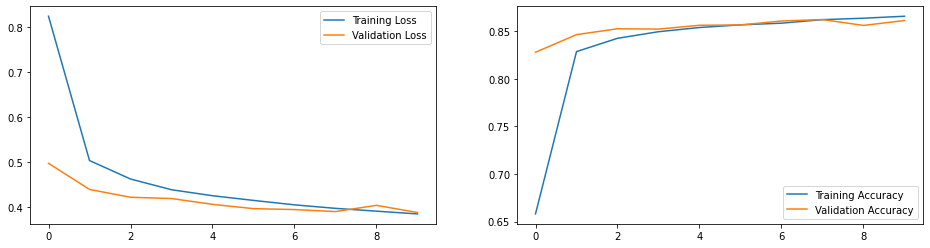

In [132]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Model Architecture Summary: Single Layer Simple RNN (Experiment B3)


In [133]:
model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               16512     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 89,028
Trainable params: 89,028
Non-trainable params: 0
____________________________________________________

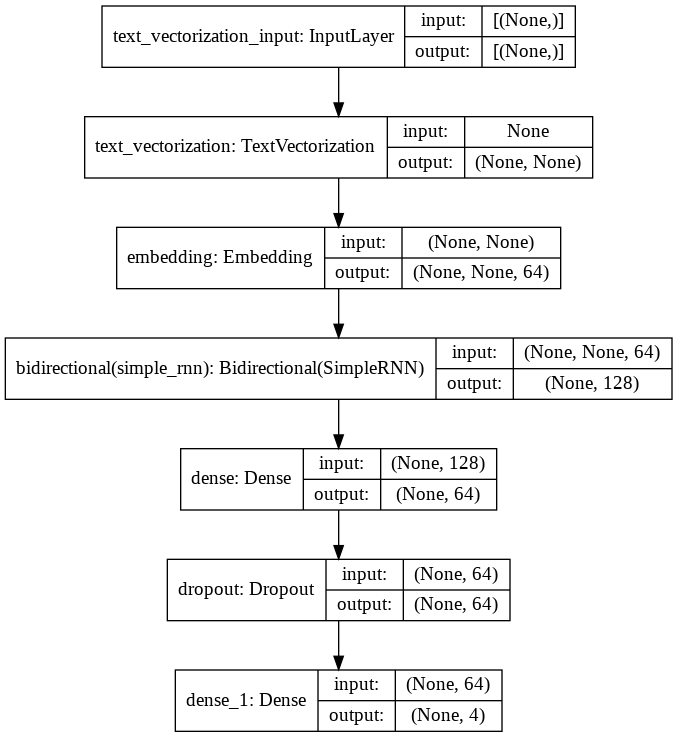

In [134]:
keras.utils.plot_model(model3, "BiDirectionalGRU.png", show_shapes=True)

##Create model: Multi Layer Bidirectional Simple RNN (Experiment B4)


Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional]?raw=1"

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [135]:
from keras import backend as K
K.clear_session()

model4 = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64,  return_sequences=True))
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(32))
                              ,tf.keras.layers.Dense(64, activation='relu')
                              ,tf.keras.layers.Dropout(0.5)
                              ,tf.keras.layers.Dense(num_classes,activation='softmax')   # not binary since there are num_classes categories
])

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [136]:
model4.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy() # if we set from_logits=True we do not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

In [137]:
start=datetime.now()

history4 = model4.fit(train_dataset
                    ,epochs=200
                    ,validation_data=validation_dataset
                    ,validation_steps=30
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )

end=datetime.now()
print("Experiment B3 time:", end-start) 

Epoch 1/200
1782/1782 [==============================] - 523s 292ms/step - loss: 0.5702 - accuracy: 0.7886 - val_loss: 0.4386 - val_accuracy: 0.8510
Epoch 2/200
1782/1782 [==============================] - 509s 285ms/step - loss: 0.4505 - accuracy: 0.8442 - val_loss: 0.4282 - val_accuracy: 0.8562
Epoch 3/200
1782/1782 [==============================] - 510s 286ms/step - loss: 0.4315 - accuracy: 0.8502 - val_loss: 0.4314 - val_accuracy: 0.8396
Epoch 4/200
1782/1782 [==============================] - 511s 286ms/step - loss: 0.4114 - accuracy: 0.8566 - val_loss: 0.4386 - val_accuracy: 0.8448
Experiment B3 time: 0:34:11.751889


In [138]:
test_loss, test_acc = model4.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

119/119 [==============================] - 3s 27ms/step - loss: 0.4272 - accuracy: 0.8487
Test Loss: 0.42724525928497314
Test Accuracy: 0.8486841917037964


## Plotting Performance Metrics: Multi Layer Bidirectional Simple RNN (Experiment B4)

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [139]:
history_dict4 = history4.history
history_dict4.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [140]:
history4_df=pd.DataFrame(history_dict4)
history4_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.570,0.789,0.439,0.851
1,0.450,0.844,0.428,0.856
2,0.432,0.850,0.431,0.840
3,0.411,0.857,0.439,0.845


In [141]:
losses = history4.history['loss']
accs = history4.history['accuracy']
val_losses = history4.history['val_loss']
val_accs = history4.history['val_accuracy']
epochs = len(losses)

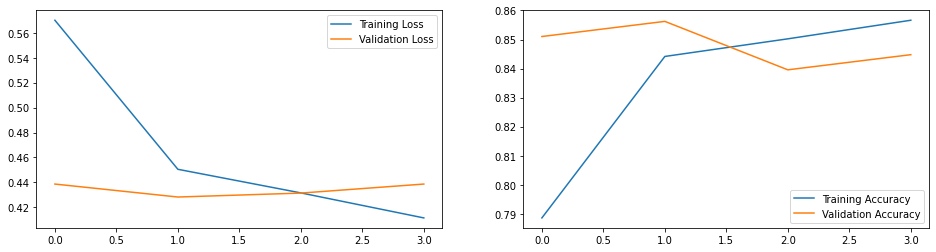

In [142]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

### Confusion Matrix

In [143]:
preds = model4.predict(test_dataset)

In [144]:
preds.shape

(7600, 4)

In [145]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [146]:
df = pd.DataFrame(preds[0:15]
                  ,columns = ['World','Sports','Business','Sci/Tech']).T
df.style.format("{:.2%}").background_gradient(cmap=cm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
World,0.13%,98.88%,0.12%,1.23%,99.86%,0.21%,1.69%,7.46%,85.99%,0.64%,99.69%,0.11%,0.58%,88.80%,99.88%
Sports,99.86%,0.01%,0.06%,98.56%,0.00%,0.18%,97.78%,91.32%,0.30%,0.08%,0.00%,0.15%,0.01%,0.44%,0.00%
Business,0.02%,0.97%,7.49%,0.11%,0.12%,14.51%,0.20%,0.13%,5.65%,73.98%,0.25%,1.94%,98.90%,3.17%,0.09%
Sci/Tech,0.00%,0.14%,92.33%,0.10%,0.03%,85.10%,0.33%,1.10%,8.06%,25.30%,0.06%,97.79%,0.50%,7.59%,0.03%


#### Model Architecture Summary: Multi Layer Bidirectional Simple RNN (Experiment B4)

In [147]:
model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         16512     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                10304     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2

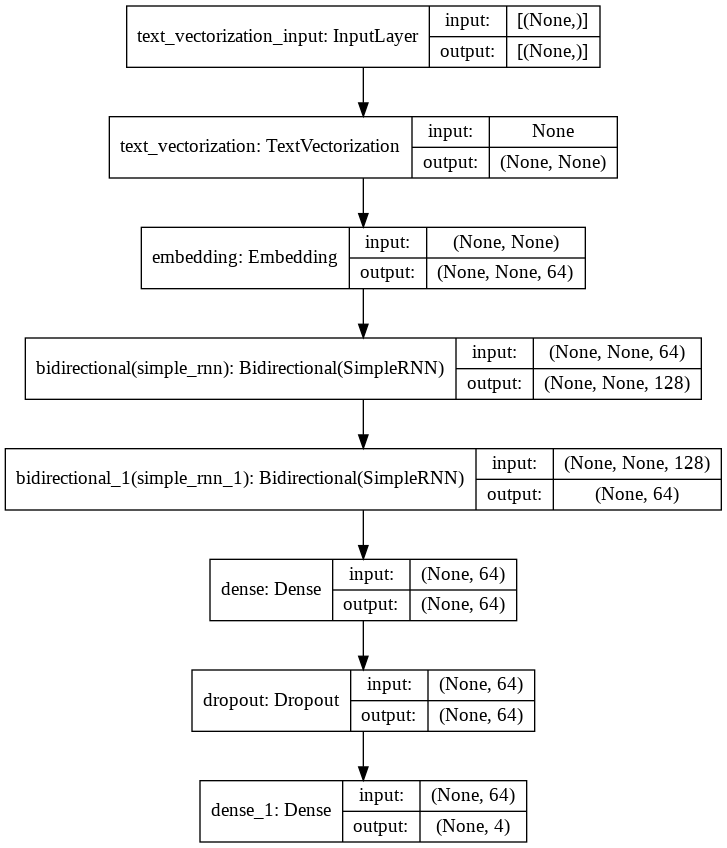

In [148]:
keras.utils.plot_model(model4, "2Layer_BiDirectionalGRU.png", show_shapes=True)

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](../../guide/keras/rnn.ipynb).
